##LGBM on Image and Text Embeddings 

Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In [1]:
!pip install lightgbm

In [2]:
# imports
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from tqdm.notebook import tqdm, trange
import json

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import lightgbm as lgb

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Importing all the Concat Embeddings of Text and Images reducing them to 100 dim using PCA.

In [4]:
concat_embeddings = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/roberta_retrain_ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [5]:
concat_embeddings_val = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/roberta_retrain_ConcatEmbeddings_dev_unseen.csv")
concat_embeddings_val.rename(columns={"0": "id"}, inplace=True)

In [6]:
concat_embeddings_test_unseen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/roberta_retrain_ConcatEmbeddings_test_unseen.csv")
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)
concat_embeddings_test_seen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/roberta_retrain_ConcatEmbeddings_test_seen.csv")
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

In [7]:
train_data = pd.read_json("/content/gdrive/MyDrive/522-project/train.jsonl", lines=True)


train_embed = concat_embeddings[concat_embeddings.id.isin(train_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
target_train = train_data["label"].tolist()
train_embed = np.array(train_embed)
target_train = np.array(target_train)



In [8]:
val_data = pd.read_json("/content/gdrive/MyDrive/522-project/dev_unseen.jsonl", lines=True)

val_embed= concat_embeddings_val[concat_embeddings_val.id.isin(val_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
val_target = val_data["label"].tolist()

val_embed = np.array(val_embed)
val_target = np.array(val_target)

In [9]:
test_unseen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_unseen.jsonl", lines=True)

test_unseen_embed= concat_embeddings_test_unseen[concat_embeddings_test_unseen.id.isin(test_unseen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_unseen_target = test_unseen_data["label"].tolist()

test_unseen_embed = np.array(test_unseen_embed)
test_unseen_target = np.array(test_unseen_target)

In [10]:
test_seen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_seen.jsonl", lines=True)

test_seen_embed= concat_embeddings_test_seen[concat_embeddings_test_seen.id.isin(test_seen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_seen_target = test_seen_data["label"].tolist()

test_seen_embed = np.array(test_seen_embed)
test_seen_target = np.array(test_seen_target)

## Fitting the cocatenated Train embedding on the LGBM Model

We fine tuned the LGBM model on various parameters such as :  

1. n-estimators
2. number of leaves
3. iterations
4. maximum depth

In [11]:
model_lgb = lgb.LGBMClassifier(max_depth= 3, num_leaves=2, num_iterations = 1000, n_estimators = 1000)


Training the model 

In [12]:
model_lgb.fit(train_embed, target_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(max_depth=3, n_estimators=1000, num_iterations=1000,
               num_leaves=2)

## Testing on the Validation Set

ROC Curve : 0.5027352941176471


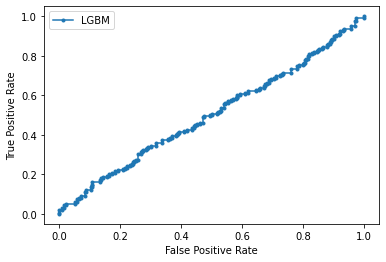

precision :0.3829787234042553 recall :0.09 f1 :0.145748987854251 accuracy :0.6092592592592593


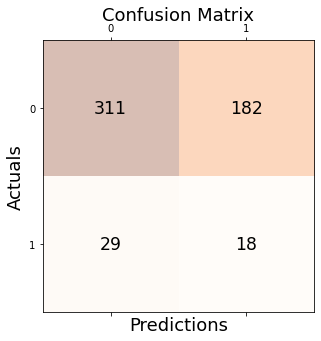

Precision vs Recall


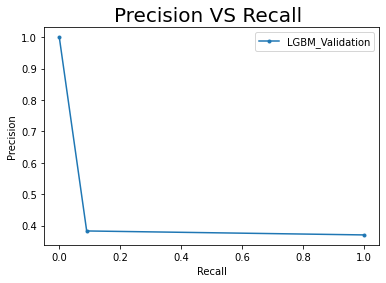

In [19]:
pred_y_xg_val = model_lgb.predict(val_embed)
lr_probs = model_lgb.predict_proba(val_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(val_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(val_target, lr_probs)
print("ROC Curve : " + str(lr_auc))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

precision, recall, f1, _ = precision_recall_fscore_support(val_target, pred_y_xg_val, average='binary')
acc = accuracy_score(val_target, pred_y_xg_val)
r = confusion_matrix(pred_y_xg_val, val_target)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(val_target, pred_y_xg_val)
pyplot.plot(recall1, precision1, marker='.', label='LGBM_Validation')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()


## Testing on Test Seen Data

ROC Curve : 0.5757623049219688


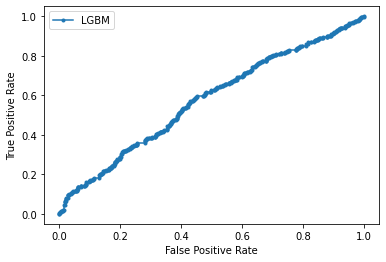

precision :0.5853658536585366 recall :0.19591836734693877 f1 :0.2935779816513761 accuracy :0.538


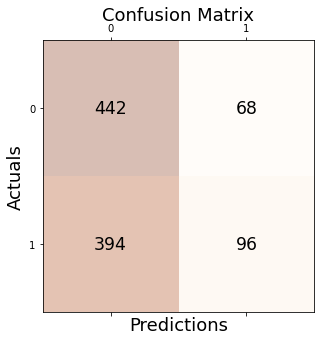

Precision vs Recall


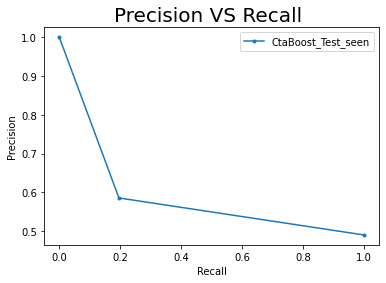

In [20]:
preds = model_lgb.predict(test_seen_embed)
lr_probs = model_lgb.predict_proba(test_seen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_seen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_seen_target, lr_probs)
print("ROC Curve : " + str(lr_auc))

pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_seen_target, preds, average='binary')
acc = accuracy_score(test_seen_target, preds)

r = confusion_matrix(test_seen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(test_seen_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CtaBoost_Test_seen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

## Testing on the unseen test data

ROC Curve : 0.5701994666666667


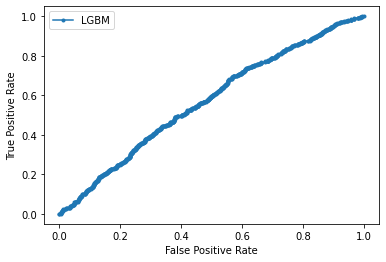

precision :0.44280442804428044 recall :0.16 f1 :0.23506366307541623 accuracy :0.6095


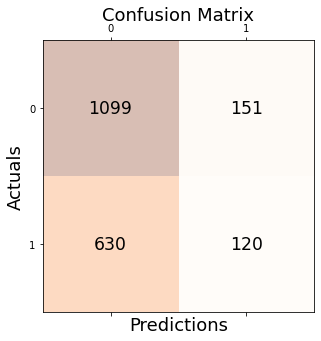

Precision vs Recall


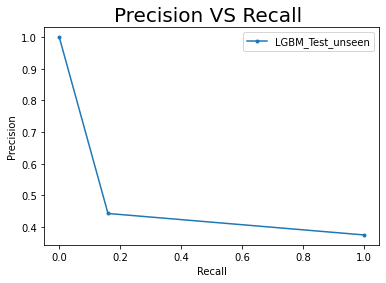

In [21]:
preds = model_lgb.predict(test_unseen_embed)
lr_probs = model_lgb.predict_proba(test_unseen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_unseen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_unseen_target, lr_probs)
print("ROC Curve : " + str(lr_auc))

pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_unseen_target, preds, average='binary')
acc = accuracy_score(test_unseen_target, preds)
r = confusion_matrix(test_unseen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision1, recall1, thresholds = precision_recall_curve(test_unseen_target, preds)
print("Precision vs Recall")
pyplot.plot(recall1, precision1, marker='.', label='LGBM_Test_unseen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()